# Gold recovery from gold ore

## Project description

### Task

It is needed to build model wich will be predict the gold recovery rate from gold ore. 
There is 3 data files:
- gold_recovery_train_new.csv — train data
- gold_recovery_test_new.csv — test data
- gold_recovery_full_new.csv — initial data

Data is indexed by data and time getting information. Near by time parameters are often similar. Some parameters are unavailable because they are measuring and calculating much later. That is why in the test data some features are missing which is having in the train data. Also test data has no target features.

### Technology process


1. Rougher (flotation): gold ore is fed into the flotation plant. After enrichment, a rough concentrate and “dump tails” are obtained. The stability of this process is affected by the unstable and non-optimal physico-chemical state of the flotation pulp (a mixture of solid particles and liquid).
2. Clearning: rough concentrate goes through two purifications. The output is the final concentrate and final tails.

### Data description


Process:
- Rougher feed
  - Rougher additions: Xanthate, Sulphate, Depressant
- Rougher process
  - Rougher Au
  - Rougher tails
- Float banks
- Cleaner process
- Final Au

Stage parameters:
- air amount
- fluid levels
- feed size
- feed rate

Name of features

`[stage].[parameter_type].[parameter_name]`
 - Example: rougher.input.feed_ag

Possible values for block `[stage]`:
 - rougher
 - primary_cleaner
 - secondary_cleaner
 - final - final characteristics

Possible values for block `[parameter_type]`:
 - input — raw material parameters
 - output - product parameters
 - state — parameters characterizing the current state of the stage
 - calculation — calculated characteristics

### Recovery



It is needed to calculate gold recovery. Recovery formula:

$$ \frac {C * (F - T)}{F * (C - T)}\ * 100 \%\ $$

Where 
- C - proportion of gold in the concentrate after flotation
- F - proportion of gold in the concentrate before flotation
- T - proportion of gold in tailings after flotation

### Quality metric



sMAPE (Symmetric Mean Absolute Percentage Error):

$$ \frac {1}{N}\ \sum_{i=1}^{N} \frac {|y_i - \hat y_i|}{(|y_i| + |\hat y_i|)/2} * 100 \%\ $$

Where
- $y_i$ - target value num i
- $\hat y_i$ - prediction value num i
- $N$ - the number of objects in the sample

It is needed to predict two quantity:
- rougher.output.recovery;
- final.output.recovery. 

The final metric consists of two quantities:

$$ final \ \ sMAPE = 25 \%\ * sMAPE(rougher) + 75 \%\ * sMAPE(final) $$

## Data preparation

### Data downloading

In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

!pip install catboost
from catboost import CatBoostRegressor
from catboost import Pool
from catboost import cv

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import  StandardScaler

from scipy import stats

import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [ ]:
# for google colab:
from google.colab import drive
drive.mount('/content/gdrive')

df_train = pd.read_csv('gdrive/My Drive/colab_notebooks/9-gold-mining/data/gold_recovery_train_new.csv')#, sep='\t')
df_test = pd.read_csv('gdrive/My Drive/colab_notebooks/9-gold-mining/data/gold_recovery_test_new.csv')#, sep='\t')
df_full = pd.read_csv('gdrive/My Drive/colab_notebooks/9-gold-mining/data/gold_recovery_full_new.csv')#, sep='\t')

Mounted at /content/gdrive


In [ ]:
df_train.shape

(14149, 87)

In [ ]:
df_test.shape

(5290, 53)

In [ ]:
df_full.shape

(19439, 87)

In [ ]:
df_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,...,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,...,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.497069,19.369147,34.118526,16.250511,3.049646,6.733907,2.353017,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,1574.479259,-498.931665,42050.861809,3498.370979,3489.981857,2.858998,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,...,20.050975,86.843261,

#### Conclusion

Data was downloaded and DataFrames were created:
 - `df_train`
 - `df_tes`
 - `df_full`

### Columns analisys

In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [ ]:
columns_no_in_test = [x for x in df_train.columns if x not in df_test.columns]
columns_no_in_test

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

It is a block diagram was built after analyzing data and conditions:

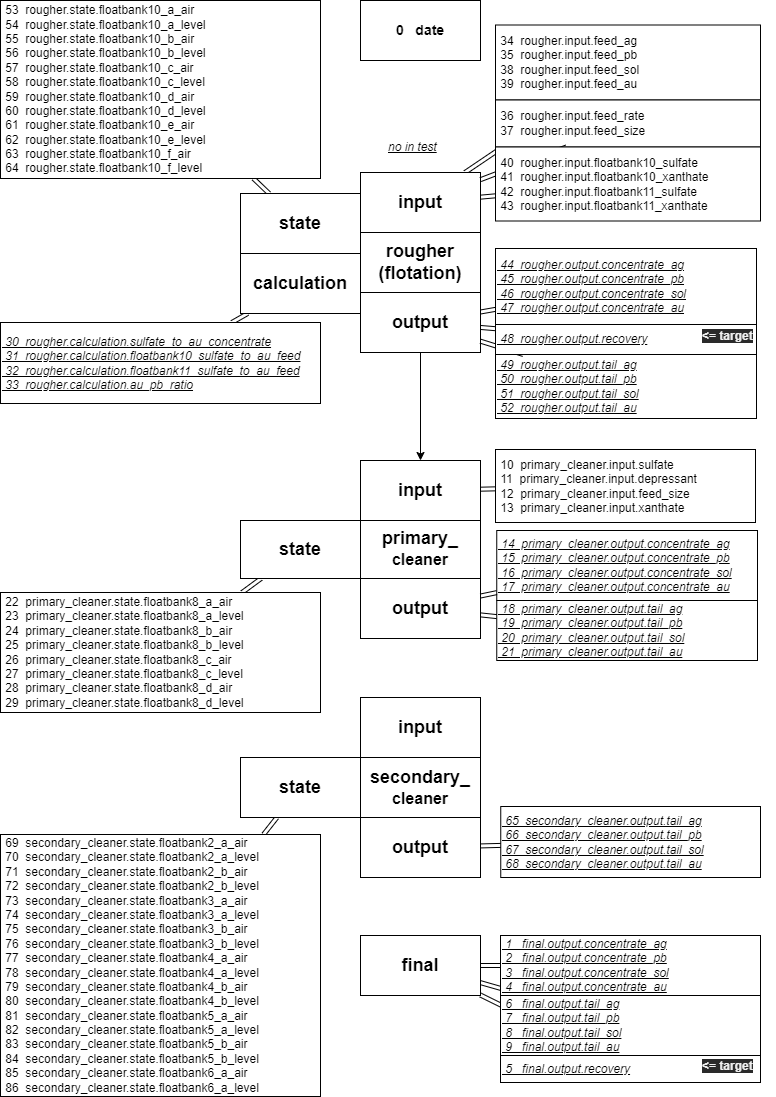

List with target columns

In [ ]:
columns_for_prediction = ['rougher.output.recovery',
                          'final.output.recovery']

### Recovery calculation and checking on train data

In [ ]:
C = 'rougher.output.concentrate_au'
F = 'rougher.input.feed_au'
T = 'rougher.output.tail_au'

In [ ]:
df_train['recovery'] = (df_train[C] * (df_train[F] - df_train[T])) / (df_train[F] * (df_train[C] - df_train[T])) * 100

In [ ]:
df_train[['recovery',  'rougher.output.recovery']].sample(3)

,recovery,rougher.output.recovery
3520,71.133864,71.133864
3445,81.471884,81.471884
3842,85.406993,85.406993


In [ ]:
round(mean_absolute_error(df_train['rougher.output.recovery'], df_train['recovery']), 5)

0.0

#### NaN analisys

In [ ]:
pd.DataFrame(df_full.isna().sum(),
             columns=['sum_nan']
             ).sort_values(by='sum_nan', ascending=False).head(5)

,sum_nan
secondary_cleaner.output.tail_sol,1748
rougher.input.floatbank11_xanthate,453
rougher.state.floatbank10_e_air,436
primary_cleaner.output.concentrate_sol,370
secondary_cleaner.state.floatbank2_a_air,220


Many columns have NaN values, and without chemist consultation it is unknown how to fill them. But the rows are located in time process order and can be filled by values from previous rows

Changing format to date and sorting

In [ ]:
df_full['date'] = pd.to_datetime(df_full['date'], format='%Y-%m-%d %H:%M:%S')
df_train['date'] = pd.to_datetime(df_full['date'], format='%Y-%m-%d %H:%M:%S')
df_test['date'] = pd.to_datetime(df_full['date'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
df_full.sort_values(by='date', inplace=True)
df_train.sort_values(by='date', inplace=True)
df_test.sort_values(by='date', inplace=True)

Filling NaN values

In [ ]:
df_full = df_full.fillna(method='ffill')
df_train = df_train.fillna(method='ffill')
df_test = df_test.fillna(method='ffill')

#### Conclusion

NaN values were filled by values from previous time's rows. It was created a list `columns_for_prediction` with target columns names. It was created and checked the recovery column

## Data analisys

### Checking metal concentrations in the different process stages

Custom function for building plot

In [ ]:
class myfunc:
  '''Custom functions'''

In [ ]:
def df_plots(dic,
             title_text='Boxblot', kind='Box',
             rows=1, cols=1, height=500, width=800,
             shared_yaxes=False,
             y_for_Bar=''):
  '''Function receives dictionary with df and list columns names,
  when builds Boxblot or Histogram or Bar
  - imports:
  import plotly.graph_objs as go
  from plotly.subplots import make_subplots'''

  fig = make_subplots(rows=rows, cols=cols, shared_yaxes=shared_yaxes)
  row = 1
  col = 1
  for key, val in dic.items():
    if kind == 'Box':
      fig.append_trace(go.Box(y=eval(key)[val], name=(key + '-' + val)), row, col)
    elif kind == 'Histogram':
      fig.append_trace(go.Histogram(y=eval(key)[val], name=key + '-' + val), row, col)
    elif kind == 'Bar':
      fig.append_trace(go.Bar(x=eval(key)[val],y=eval(key)[y_for_Bar],name=key + '-' + val), row, col)
    col += 1
    if col > cols:
      col = 1
      row +=1
  
  fig.update_layout(title_text=title_text, height=height, width=width)
  fig.show()

myfunc.df_plots =  df_plots

Checking amount of metal concentrates in different stages in df_train

In [ ]:
list_features = ['.concent', '.feed']
concentrations = [col for col in df_train.columns if
                  [elem for elem in list_features if(elem in col)]
                  ]
list_metals = ['_ag', '_pb', '_sol', '_au']

In [ ]:
concentrations

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au']

In [ ]:
cons_mean_df = pd.DataFrame(columns=['features', 'mean_'])
mean_df= pd.DataFrame(columns=['features', 'mean_', 'process', 'metal'])

for metal in list_metals:
  for val in concentrations:
    if metal in val:
      cons_mean_df = cons_mean_df.append([{'features': val,
                                           'mean_': df_train[val].mean(),
                                           'metal': metal}])
  cons_mean_df['process'] = ['4 fin out', '3 prim out', '1 rou in', '2 rou out']
  cons_mean_df = cons_mean_df.sort_values(by='process')
  mean_df = mean_df.append(cons_mean_df)
  cons_mean_df = cons_mean_df.iloc[0:0]

dic_for_plot = {}
for metal in list_metals:
  str_ = ('mean_df[mean_df["metal"] == ' +
          '"' + 
          metal + 
          '"]')
  dic_for_plot[str_] = 'process'

myfunc.df_plots(dic_for_plot,
                "Metals mean concentration in train data", 'Bar',
                rows=2, cols=2,
                height=800, width=1200,
                y_for_Bar='mean_')

#### Conclusion

During process recovery gold the concentration of sol (there is no definition in the task) and silver are drop down and the gold and lead concentrations are grown

### Checking feed rate and size

It is necessary to check feed rate and size in test and train data for right prediction

In [ ]:
myfunc.df_plots({'df_train' : 'rougher.input.feed_rate',
                 'df_test' : 'rougher.input.feed_rate'},
                title_text='Feed rate',
                cols=2, shared_yaxes=True)

In [ ]:
myfunc.df_plots({'df_train' : 'rougher.input.feed_size',
                 'df_test' : 'rougher.input.feed_size'},
                title_text='Feed size',
                cols=2, shared_yaxes=True)

#### Conclusion

Feed size and rate indicators in train and test data is close, so it is possible to train model and predict

### Checking amount of inputted metals

In [ ]:
df_train['total_input_metals'] = (df_train['rougher.input.feed_ag'] + 
                                  df_train['rougher.input.feed_pb'] +
                                  df_train['rougher.input.feed_au'])
df_test['total_input_metals'] = (df_test['rougher.input.feed_ag'] + 
                                  df_test['rougher.input.feed_pb'] +
                                  df_test['rougher.input.feed_au'])
myfunc.df_plots({'df_train' : 'total_input_metals',
                 'df_test' : 'total_input_metals'},
                title_text='Total sum of inputed metals in test and train data',
                cols=2, width=800)

Probably the values near zero are mistaken, because it is unclear why is needed to start process without metals. So it is necessary to drop outliers below quantile 5%

In [ ]:
df_train = df_train[df_train['total_input_metals'].between(
    df_train['total_input_metals'].quantile(.005),
    df_train['total_input_metals'].quantile(1))]

In [ ]:
df_test = df_test[df_test['total_input_metals'].between(
    df_test['total_input_metals'].quantile(.005),
    df_test['total_input_metals'].quantile(1))]

In [ ]:
myfunc.df_plots({'df_train' : 'total_input_metals',
                 'df_test' : 'total_input_metals'},
                title_text='Total sum of inputted metals in test and train data without outliers',
                cols=2, width=800)

#### Conclusion

Outliers by column `total_input_metals` below quantile 5% was dropped

### Checking total materials sum

Checking total materials in df_train

Adding metals to temp df

In [ ]:
cons_sum_df = pd.DataFrame(columns=['features', 'sum_', 'material'])
cons_sum_df_all= pd.DataFrame(columns=['features', 'sum_', 'process', 'material'])

for metal in list_metals:
  for val in concentrations:
    if metal in val:
      cons_sum_df = cons_sum_df.append([{'features': val,
                                         'sum_': df_train[val].sum(),
                                         'material': metal}])
  cons_sum_df['process'] = ['5 final output', '4 primary output', '1 rougher input', '2 rougher output']
  cons_sum_df = cons_sum_df.sort_values(by='process')

  cons_sum_df_all = cons_sum_df_all.append(cons_sum_df)
  cons_sum_df = cons_sum_df.iloc[0:0]

In [ ]:
cons_sum_df_all.head(5)

,features,sum_,process,material
0,rougher.input.feed_ag,121081.294590,1 rougher input,_ag
0,rougher.output.concentrate_ag,165854.730290,2 rougher output,_ag
0,primary_cleaner.output.concentrate_ag,115670.296766,4 primary output,_ag
0,final.output.concentrate_ag,72437.743691,5 final output,_ag
0,rougher.input.feed_pb,49535.293166,1 rougher input,_pb


Adding reagents to temp df

In [ ]:
list_additions = ['sulfate', 'xanthate', 'depressant']
additions = [col for col in df_train.columns if
                  [elem for elem in list_additions if(elem in col)]
                  ]
additions

['primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.xanthate',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate']

In [ ]:
del additions[3:6]
additions

['primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.xanthate',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate']

In [ ]:
for val in additions:
  cons_sum_df = cons_sum_df.append([{'features': val, 'sum_': df_train[val].sum()}])
cons_sum_df['process'] = ['3 primary input', '3 primary input','3 primary input',
                          '1 rougher input','1 rougher input','1 rougher input','1 rougher input']
cons_sum_df['material'] = ['sulfate','depressant','xanthate',
                          'sulfate','xanthate','sulfate','xanthate']
cons_sum_df_all = cons_sum_df_all.append(cons_sum_df)

In [ ]:
pivot_ = cons_sum_df_all.pivot_table(values='sum_',
                                     index=['process', 'material'],
                                     aggfunc="sum").reset_index()

myfunc.df_plots({'pivot_': 'process'}, title_text='Total material sum', kind='Bar', height=500, width=800, y_for_Bar='sum_')

In [ ]:
fig = make_subplots(2, 3, specs=[
                                 [{'type':'domain'},{'type':'domain'},{'type':'domain'}],
                                  [{'type':'domain'},{'type':'domain'},{'type':'domain'}]
                                  ],
                    subplot_titles=['1 rougher input', '2 rou out', '3 primary input', '4 primary output', '5 final output'])
fig.add_trace(go.Pie(labels=pivot_[pivot_['process'] == '1 rougher input']['material'],
                     values=pivot_[pivot_['process'] == '1 rougher input']['sum_'], scalegroup='one',
                     name='1 rougher input'), 1, 1)
fig.add_trace(go.Pie(labels=pivot_[pivot_['process'] == '2 rougher output']['material'],
                     values=pivot_[pivot_['process'] == '2 rougher output']['sum_'], scalegroup='one',
                     name='2 rougher output'), 1, 2)
fig.add_trace(go.Pie(labels=pivot_[pivot_['process'] == '3 primary input']['material'],
                     values=pivot_[pivot_['process'] == '3 primary input']['sum_'], scalegroup='one',
                     name='3 primary input'), 1, 3)
fig.add_trace(go.Pie(labels=pivot_[pivot_['process'] == '4 primary output']['material'],
                     values=pivot_[pivot_['process'] == '4 primary output']['sum_'], scalegroup='one',
                     name='4 primary output'), 2, 1)
fig.add_trace(go.Pie(labels=pivot_[pivot_['process'] == '5 final output']['material'],
                     values=pivot_[pivot_['process'] == '5 final output']['sum_'], scalegroup='one',
                     name='5 final output'), 2, 2)

fig.update_layout(title_text='Total material sum', height=800, width=1000)
fig.show()

#### Conclusion

Gold concentration is increased from step to step. In primary cleaner there are a lot of sulfate

Custom function to calculate sMAPE

In [ ]:
def sMAPE_func(y_true, y_pred):
  '''Metric description
  https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error'''
  N = len(y_true)
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)
  return 1 / N * sum(np.abs(y_true - y_pred) /
                     ((np.abs(y_true) + np.abs(y_pred)) / 2)
                     ) * 100

## Model buiding

### Finding the best model

In [ ]:
RANDOM = 123456

Some custom functions, descriptions are inside

In [ ]:
def regression_metrics_df(y_valid, list_data):
  '''Function receives y_valid data and list which contains
  lists [name (text model name),
  probabilities (model.predict_proba),
  prediction (model.predict),
  caption (text caption in df)] 
  then returns a classification report
  - imports
  from sklearn.metrics import classification_report'''
  # for sMAPE:
  np.seterr(divide='ignore', invalid='ignore') # to avoid: RuntimeWarning: invalid value encountered in divide

  sanity_result = pd.DataFrame()
  for list_value in list_data:
      prediction = list_value[1]
      dict_ = {'model_type': list_value[0],
              'caption': list_value[2],
              'MAE': mean_absolute_error(prediction, y_valid),
              'sMAPE': sMAPE_func(y_valid, prediction)}
      sanity_df = pd.DataFrame([dict_])

      if sanity_result.size == 0:
        sanity_result = sanity_df
      else:
        sanity_result = sanity_result.append(sanity_df)
  return sanity_result

myfunc.regression_metrics_df = regression_metrics_df

In [ ]:
def compare_regression_models (splitted_df, caption):
  '''Function receives dict of splitted data (which is returned function split_df()).
  It builds a few kinds of models.
  Function returns a classification report of models (call function classification_df())
  If is_show_plot=True then in will build a plot (call function myfunc.plot_roc()) for each kind of models.'''
  list_data = []
  RANDOM = 123456
# linear
  model_linear = LinearRegression().fit(splitted_df['X_train'], splitted_df['y_train'])
  list_data.append(['linear',
                model_linear.predict(splitted_df['X_valid']),
                caption])
# forest
  model_forest = DecisionTreeRegressor(random_state=RANDOM,
                                        ).fit(splitted_df['X_train'], splitted_df['y_train'])
  list_data.append(['forest',
                    model_forest.predict(splitted_df['X_valid']),
                    caption]) 
# CatBoost
  model_cat_boost = CatBoostRegressor(random_state=RANDOM,
                                        loss_function='MAE',
                                        logging_level='Silent').fit(splitted_df['X_train'], splitted_df['y_train'])
  list_data.append(['cat boost',
                    model_cat_boost.predict(splitted_df['X_valid']),
                    caption])
  return myfunc.regression_metrics_df(splitted_df['y_valid'], list_data) 

myfunc.compare_regression_models = compare_regression_models

In [ ]:
def split_df(df, list_dpop_cols_names, target_col_name, need_test=False, cv=False):
  '''Function receives DataFrame, split it to train (60%), valid (20%), test (20%) data,
  also receives list of names columns to drop and target column name.
  Returns data as dict,
  Function also print the splitted data shape
  If need_test=True function returns dict with train 75% and test 25% data
  If cv=True function returns dict just was separated for X and y
  - imports:
  from sklearn.model_selection import train_test_split'''
  list_dpop_cols_names.append(target_col_name)
  X = df.drop(list_dpop_cols_names, axis=1)
  y = df[target_col_name]
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=123456)
  X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=123456)
  
  if need_test:
    print('X_train:',X_train.shape,'X_valid:',X_valid.shape,'X_test:', X_test.shape)
    return {'X_train': X_train, 'y_train': y_train, 'X_valid': X_valid, 'y_valid': y_valid, 'X_test': X_test, 'y_test': y_test}
  if cv:
    print(X.shape)
    return {'X_train': X, 'y_train': y}
  else:
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.75, random_state=123456)
    print('X_train:',X_train.shape,'X_valid:', X_valid.shape)
    return {'X_train': X_train, 'y_train': y_train, 'X_valid': X_valid, 'y_valid': y_valid}

myfunc.split_df = split_df

Will be build 3 kinds of models LinearRegression, DecisionTreeRegressor and CatBoostRegressor on 3 kinds of test data - non modified, without outliers and on scaled data. Result will be saved in DataFrame

Model research for target `rougher.output.recovery`

In [ ]:
df_train_copy = df_train.copy().drop(['date', 'recovery', 'total_input_metals'], axis=1)

In [ ]:
# non modified
dict_ = myfunc.split_df(df_train_copy, columns_no_in_test, columns_for_prediction[0])
metrics_sum = myfunc.compare_regression_models(splitted_df=dict_, caption='non modified df')

X_train: (10558, 52) X_valid: (3520, 52)


In [ ]:
# drop outliers
dict_['X_train'] = dict_['X_train'][(np.abs(stats.zscore(dict_['X_train'])) < 4).all(axis=1)]
dict_['y_train'] = dict_['y_train'].loc[dict_['X_train'].index]
metrics_sum = metrics_sum.append(myfunc.compare_regression_models(splitted_df=dict_, caption='without outliers df'))

In [ ]:
1 - (len(dict_['X_train']) + len(dict_['X_valid'])) / len(df_train)

0.0897854808921722

After drop outliers the data decreased by 9%

In [ ]:
# scale
scaler = StandardScaler()
df_train_scalled = pd.DataFrame(scaler.fit_transform(df_train_copy), columns=df_train_copy.columns)
dict_ = myfunc.split_df(df_train_scalled, columns_no_in_test, columns_for_prediction[0])
metrics_sum = metrics_sum.append(myfunc.compare_regression_models(splitted_df=dict_, caption='scalled df'))

X_train: (10558, 52) X_valid: (3520, 52)


In [ ]:
metrics_sum.sort_values(by='sMAPE')

,model_type,caption,MAE,sMAPE
0,cat boost,non modified df,3.949172,7.922583
0,cat boost,without outliers df,4.324092,8.507989
0,linear,non modified df,6.501349,10.494046
0,linear,without outliers df,7.911951,12.646734
0,cat boost,scalled df,0.275696,63.324462
0,forest,scalled df,0.321113,68.823635
0,linear,scalled df,0.451600,101.980241
0,forest,non modified df,4.632774,NaN
0,forest,without outliers df,5.397380,NaN


#### Conclusion

The best metrics has the catboost model on non modified data. Let's tuning that model.

### Model tuning

Getting cross validation scores

In [ ]:
dict_ = myfunc.split_df(df_train_copy, columns_no_in_test, columns_for_prediction[0], cv=True)

(14078, 52)


In [ ]:
model_rougher = CatBoostRegressor(random_state=RANDOM,
                                    loss_function='MAE',
                                    iterations=10000)

In [ ]:
cv_data = cv(
    Pool(dict_['X_train'],
          dict_['y_train']),
    model_rougher.get_params(),
    # logging_level='Silent',
    verbose=1000
)
cv_data.sort_values(by='test-MAE-mean').head(5)

Training on fold [0/3]
0:	learn: 80.3851099	test: 80.1673757	best: 80.1673757 (0)	total: 15ms	remaining: 2m 29s
1000:	learn: 3.1262789	test: 3.7027736	best: 3.7027736 (1000)	total: 12.9s	remaining: 1m 56s
2000:	learn: 2.5657376	test: 3.5853799	best: 3.5788233 (1832)	total: 25.8s	remaining: 1m 43s
3000:	learn: 2.3033836	test: 3.5672844	best: 3.5660693 (2965)	total: 38.6s	remaining: 1m 30s
4000:	learn: 2.1215326	test: 3.5659220	best: 3.5606262 (3327)	total: 51.5s	remaining: 1m 17s
5000:	learn: 1.9928726	test: 3.5648305	best: 3.5606262 (3327)	total: 1m 4s	remaining: 1m 4s
6000:	learn: 1.8813257	test: 3.5716356	best: 3.5606262 (3327)	total: 1m 17s	remaining: 51.8s
7000:	learn: 1.8015796	test: 3.5781922	best: 3.5606262 (3327)	total: 1m 30s	remaining: 38.8s
8000:	learn: 1.7279099	test: 3.5838381	best: 3.5606262 (3327)	total: 1m 43s	remaining: 25.9s
9000:	learn: 1.6634304	test: 3.5884656	best: 3.5606262 (3327)	total: 1m 56s	remaining: 12.9s
9999:	learn: 1.6067966	test: 3.5909428	best: 3.56062

,iterations,test-MAE-mean,test-MAE-std,train-MAE-mean,train-MAE-std
4718,4718,3.597643,0.082838,2.079618,0.061945
4714,4714,3.597648,0.082848,2.080056,0.061801
4717,4717,3.597650,0.082858,2.079755,0.061913
4719,4719,3.597653,0.082843,2.079523,0.061971
4716,4716,3.597664,0.082853,2.079821,0.061923


#### Conclusion

MAE on model teached by cross validation was inproved from 3.95 to 3.60



### Prediction for `rougher.output.recovery` on test data

In [ ]:
model_rougher.fit(Pool(dict_['X_train'],dict_['y_train']), # instead of X_train, y_train
                  # use_best_model=True,
                  verbose=1000)

0:	learn: 7.5162268	total: 13.6ms	remaining: 2m 16s
1000:	learn: 3.0933282	total: 13.5s	remaining: 2m 1s
2000:	learn: 2.6528978	total: 27s	remaining: 1m 48s
3000:	learn: 2.4118920	total: 40.6s	remaining: 1m 34s
4000:	learn: 2.2518108	total: 54.2s	remaining: 1m 21s
5000:	learn: 2.1404592	total: 1m 7s	remaining: 1m 7s
6000:	learn: 2.0516084	total: 1m 21s	remaining: 54.1s
7000:	learn: 1.9780775	total: 1m 34s	remaining: 40.6s
8000:	learn: 1.9105073	total: 1m 48s	remaining: 27.1s
9000:	learn: 1.8524347	total: 2m 1s	remaining: 13.5s
9999:	learn: 1.8060317	total: 2m 15s	remaining: 0us


In [ ]:
df_test_predicted = df_test.copy()
columns_for_prediction[0]

'rougher.output.recovery'

In [ ]:
df_test_predicted['predicted_rougher.output.recovery'] = model_rougher.predict(df_test.drop(['date', 'total_input_metals'], axis=1))

In [ ]:
df_test_predicted = pd.merge(df_test_predicted,
                             df_full[['date', columns_for_prediction[0]]],
                             on='date', how='left')

In [ ]:
print('mean_absolute_error', mean_absolute_error(df_test_predicted['predicted_rougher.output.recovery'],
                                                 df_test_predicted[columns_for_prediction[0]]))
print('sMAPE', sMAPE_func(df_test_predicted[columns_for_prediction[0]],
                          df_test_predicted['predicted_rougher.output.recovery']))

mean_absolute_error 8.96020332503045
sMAPE 13.092136979777974


#### Conclusion

On test data was predicted `rougher.output.recovery` with scores:
 - MAE 8.96
 - sMAPE 13.09

### Training and prediction for `final.output.recovery` on test data

In [ ]:
columns_for_prediction[1]

'final.output.recovery'

In [ ]:
dict_ = myfunc.split_df(df_train_copy, columns_no_in_test, columns_for_prediction[1], cv=True)

(14078, 52)


In [ ]:
model_final = CatBoostRegressor(random_state=RANDOM,
                                    loss_function='MAE',
                                    iterations=10000)

In [ ]:
model_final.fit(Pool(dict_['X_train'], dict_['y_train']), # instead of X_train, y_train
                  # use_best_model=True,
                  verbose=1000)

0:	learn: 6.6866266	total: 16.4ms	remaining: 2m 43s
1000:	learn: 3.1933359	total: 13.6s	remaining: 2m 1s
2000:	learn: 2.7355373	total: 27s	remaining: 1m 47s
3000:	learn: 2.4780222	total: 40.4s	remaining: 1m 34s
4000:	learn: 2.2991910	total: 53.7s	remaining: 1m 20s
5000:	learn: 2.1633943	total: 1m 7s	remaining: 1m 7s
6000:	learn: 2.0739360	total: 1m 20s	remaining: 53.7s
7000:	learn: 1.9870626	total: 1m 34s	remaining: 40.3s
8000:	learn: 1.9073809	total: 1m 47s	remaining: 26.8s
9000:	learn: 1.8434350	total: 2m	remaining: 13.4s
9999:	learn: 1.7876467	total: 2m 14s	remaining: 0us


In [ ]:
df_test_predicted['predicted_final.output.recovery'] = model_final.predict(df_test.drop(['date', 'total_input_metals'], axis=1))

In [ ]:
df_test_predicted = pd.merge(df_test_predicted,
                             df_full[['date', columns_for_prediction[1]]],
                             on='date', how='left')

In [ ]:
print('mean_absolute_error', mean_absolute_error(df_test_predicted['predicted_final.output.recovery'],
                                                 df_test_predicted[columns_for_prediction[1]]))
print('sMAPE', sMAPE_func(df_test_predicted[columns_for_prediction[1]],
                          df_test_predicted['predicted_final.output.recovery']))

mean_absolute_error 7.664466431343834
sMAPE 12.716911833007567


In [ ]:
final_sMAPE = (0.25 * sMAPE_func(df_test_predicted[columns_for_prediction[0]],
                          df_test_predicted['predicted_rougher.output.recovery']) + 0.75 *
               sMAPE_func(df_test_predicted[columns_for_prediction[1]],
                          df_test_predicted['predicted_final.output.recovery']))
final_sMAPE

12.81071811970017

#### Conclusion

On test data was predicted `final.output.recovery` with scores:

- MAE 7.66
- sMAPE 12.72

Final score sMAPE is 12.81

## Final conclusion

Еhe following changes have been made to the data:
- In data NaN values were filled by values from previous time's rows
- Outliers by column total_input_metals below quantile 5% was dropped

Conclusions were made in data analisys:
- During process recovery gold the concentration of sol (there is no definition in the task) and silver are drop down and the gold and lead concentrations are grown
- Gold concentration is increased from step to step. In primary cleaner there are a lot of sulfate
- Feed size and rate indicators in train and test data is close, so it is possible to train model and predict

Conclusions were made in data analisys:
- The best metrics has the catboost model on non modified data.
- On test data was predicted `rougher.output.recovery` with scores:
 - MAE 8.96
 - sMAPE 13.09
- On test data was predicted `final.output.recovery` with scores:
 - MAE 7.66
 - sMAPE 12.72
- Final score sMAPE is 12.81

It were created the following models:
- `model_final` for prediction values `final.output.recovery`
- `model_rougher` for prediction values `rougher.output.recovery`